<a href="https://colab.research.google.com/github/Sundaravelss/Creativity-Assessment-Scoring-using-NLP/blob/main/Creativity_assessment_scoring_by_Fine_tuning_Camembert_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#checking for gpu instance

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
#setting device to use gpu

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 15.9MB/s 
     |████████████████████████████████| 890kB 19.2MB/s 
     |████████████████████████████████| 3.0MB 24.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=af0daa582bdc2043bd239a883f995272710becdac0cc5e0ad70c646d36ffd35b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#loading the dataset
import pandas as pd

df=pd.read_excel('./final_data_french.xlsx')
df

,Unnamed: 0,sentence,label
0,0,Recueillir de l’eau,3.0
1,1,parachute,4.0
2,2,Protéger du soleil.,2.0
3,3,contre la pluie,1.0
4,4,protéger de la pluie,1.0
...,...,...,...
1134,1134,porte-chapeau,4.0
1135,1135,cerf volant,9.0
1136,1136,decoration murale,4.0
1137,1137,perche,4.0


In [ ]:
#counting number of unique labels(scores here)
print('no. of unique values:',len(df.label.unique()))
df.label.value_counts()

no. of unique values: 17


4.0    178
3.0    173
3.5    113
5.0    100
2.5     92
4.5     87
2.0     70
6.0     68
1.5     60
1.0     60
5.5     45
6.5     34
7.0     32
8.0     14
7.5     10
8.5      2
9.0      1
Name: label, dtype: int64

In [ ]:
#Number of classes
#df.label.value_counts(),len(df.label.unique())

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [ ]:
labels

array([3., 4., 2., ..., 4., 4., 4.])

In [ ]:
from transformers import CamembertTokenizer

from transformers import *

# Load the BERT tokenizer.
print('Loading Camembert tokenizer...')
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

Loading Camembert tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Recueillir de l’eau
Tokenized:  ['▁Recueil', 'lir', '▁de', '▁l', '’', 'eau']
Token IDs:  [27497, 14925, 8, 17, 12, 252]


In [ ]:
max_len = 0
length=[]

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    #print(len(input_ids))
    length.append(len(input_ids))
    # Update the maximum sentence tokens.
    max_len = max(max_len,len(input_ids))

print('Max sentence tokens: ', max_len)

Max sentence tokens:  63


In [ ]:
df.sentence.map(len).max()

297

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


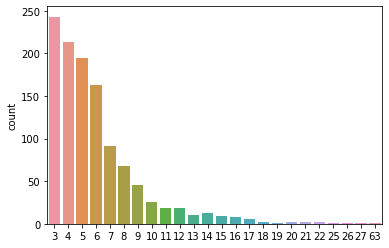

In [ ]:
import seaborn as sns

sns.countplot(length)

In [ ]:
for sent in sentences:
  if(len(sent)==297):
    print('The sentence which has the maximum number of words is:',sent, len(sent))

The sentence which has the maximum number of words is: petit récupérateur de pluie en renversant le parapluie et lui ajoutant un tuyau d'utilisation (possibilité d'en empiler en cascade pour augmenter la contenance). Accessoire de sport pour travailler la souplesse (utiliser l'anse pour par exemple attraper le pied et permettre de tirer sur la jambe) 297


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent, add_special_tokens = True, max_length = 20,pad_to_max_length = True,return_attention_mask = True, return_tensors = 'pt',truncation=True )    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Recueillir de l’eau
Token IDs: tensor([    5, 27497, 14925,     8,    17,    12,   252,     6,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])


In [ ]:
labels = torch.tensor(labels,dtype=torch.float)
labels[0]

tensor(3.)

In [ ]:
attention_masks[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,025 training samples
  114 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#hyperparameter 16 or 32
batch_size = 16
#dataloader
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size )

In [ ]:
from transformers import CamembertForSequenceClassification, AdamW, CamembertConfig

#load camembert model
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels = 17, # The number of output labels--10 (1 to 9) or --17 (if 0.5 is to be included.e.g,1,1.5,2..)
    #num_labels=1 for regression task
                       
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'cl

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [ ]:
#optimizing with adamw
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8  )


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
'''def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)'''

def flat_accuracy(preds,labels):
  labels_flat=labels.flatten()
  labels_flat=np.round(labels_flat)
  preds_flat=preds.flatten()
  preds_flat=np.round(preds_flat)
  #print(labels_flat)
  #print(preds_flat)
  length=len(labels_flat)
  accuracy=np.sum(preds_flat==labels_flat)/length
  return accuracy

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
for batch in train_dataloader:
  print(batch[0],batch[2])
  break

tensor([[    5,  3236,  6688,  3990,  2560,  2777,     6,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    5, 12421,  8053,     6,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    5, 16047,     6,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    5,  5718, 24244,     6,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    5,    28,  2466,    22,  2482,    13,  3441,     6,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    5, 24229,   621, 16279,    73,   650,     6,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    5,    84,  3533,     6,     1,   

In [ ]:
#CUDA_LAUNCH_BLOCKING="1"
import random
import numpy as np
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    #Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)


        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
      
        #input ids
        b_input_ids = batch[0].to(device)
        #attention mask
        b_input_mask = batch[1].to(device)
        #labels
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 8 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:03.

  Average training loss: 10.40
  Training epcoh took: 0:00:05

Running Validation...
  Accuracy: 0.21
  Validation Loss: 5.60
  Validation took: 0:00:00

======== Epoch 2 / 8 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:03.

  Average training loss: 3.89
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.27
  Validation Loss: 2.88
  Validation took: 0:00:00

======== Epoch 3 / 8 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:03.

  Average training loss: 2.55
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.33
  Validation Loss: 2.36
  Validation took: 0:00:00

======== Epoch 4 / 8 ========
Training...
  Batch    40  of     65.    Elapsed: 0:00:03.

  Average training loss: 2.03
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.37
  Validation Loss: 1.77
  Validation took: 0:00:00

======== Epoch 5 / 8 =====

In [ ]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,10.40,5.60,0.21,0:00:05,0:00:00
2,3.89,2.88,0.27,0:00:04,0:00:00
3,2.55,2.36,0.33,0:00:04,0:00:00
4,2.03,1.77,0.37,0:00:04,0:00:00
5,1.54,1.45,0.43,0:00:04,0:00:00
6,1.35,1.32,0.42,0:00:04,0:00:00
7,1.14,1.19,0.42,0:00:04,0:00:00
8,1.11,1.21,0.45,0:00:04,0:00:00


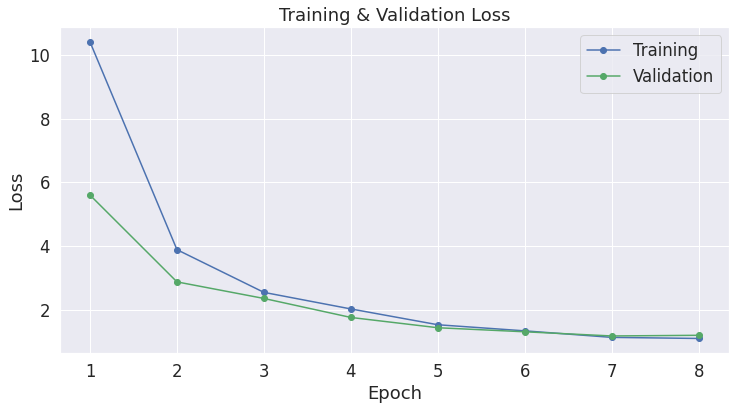

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8])

plt.show()

In [ ]:
answer="Le tenir dans le sens inverse pour porter des choses à l'exterieur"

In [ ]:
encoded_ans=tokenizer.encode_plus(answer,
                                  max_length=20,
                                  add_special_tokens=True,
                                  pad_to_max_length=True,
                                  return_attention_mask=True,
                                  return_tensors='pt',
                                  truncation=True)

In [ ]:
encoded_ans.keys

<bound method BatchEncoding.keys of {'input_ids': tensor([[    5,    54,  1852,    29,    16,   437, 10628,    24,  1499,    20,
           541,    15,    17,    11,   850, 13355,   297,     6,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}>

In [ ]:
input_ids=encoded_ans['input_ids'].to(device)
attention_mask=encoded_ans['attention_mask'].to(device)

In [ ]:
output=model(input_ids,attention_mask)

In [ ]:
output

(tensor([[4.7874]], device='cuda:0', grad_fn=<AddmmBackward>),)

In [ ]:
score=output[0][0].item()

In [ ]:
#_,prediction=torch.max(output[0],dim=1)
#prediction

In [ ]:
print(f'The user answer is: {answer}')
print(f'The calculated score is: {score}')

The user answer is: Le tenir dans le sens inverse pour porter des choses à l'exterieur
The calculated score is: 4.787374496459961


In [ ]:
#saving model
import os

output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/sentencepiece.bpe.model',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [ ]:
#load trained model
from transformers import *

model = CamembertForSequenceClassification.from_pretrained(output_dir)
tokenizer = CamembertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo